In [1]:
from tsfresh.examples import load_driftbif
from tsfresh.feature_extraction import FeatureExtractionSettings
import pandas as pd
import pprint
import timeit
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
# load data
X, _ = load_driftbif(10, 1000)
X.drop("dimension", axis=1, inplace=True)

In [3]:
# get all the parameters and respective functions
settings = FeatureExtractionSettings()
settings.set_default_parameters("value")
column_name_to_aggregate_function = settings.get_aggregate_functions("value")
apply_functions = settings.get_apply_functions("value")

In [4]:
# compare performance of tsfresh for aggregate features that are calculated individually
res  = pd.DataFrame()
n_ts = 20
l_ts = 1000
n_ti = 10

group = X.groupby("id")["value"]

for col, f in tqdm(column_name_to_aggregate_function.items()):
    res.loc[col, "feature"] = col
    res.loc[col, "n_samp"] = n_ts
    res.loc[col, "length"] = l_ts
    t = timeit.timeit(lambda : group.aggregate(f), number=n_ti)
    res.loc[col, "t_abs"] = t
    res.loc[col, "t_1ts"] = t*1.0/n_ts

100%|██████████| 130/130 [11:18<00:00, 34.10s/it]


In [5]:
res["feature"] = res.feature.astype(str)
res = res.sort_values(by="feature")

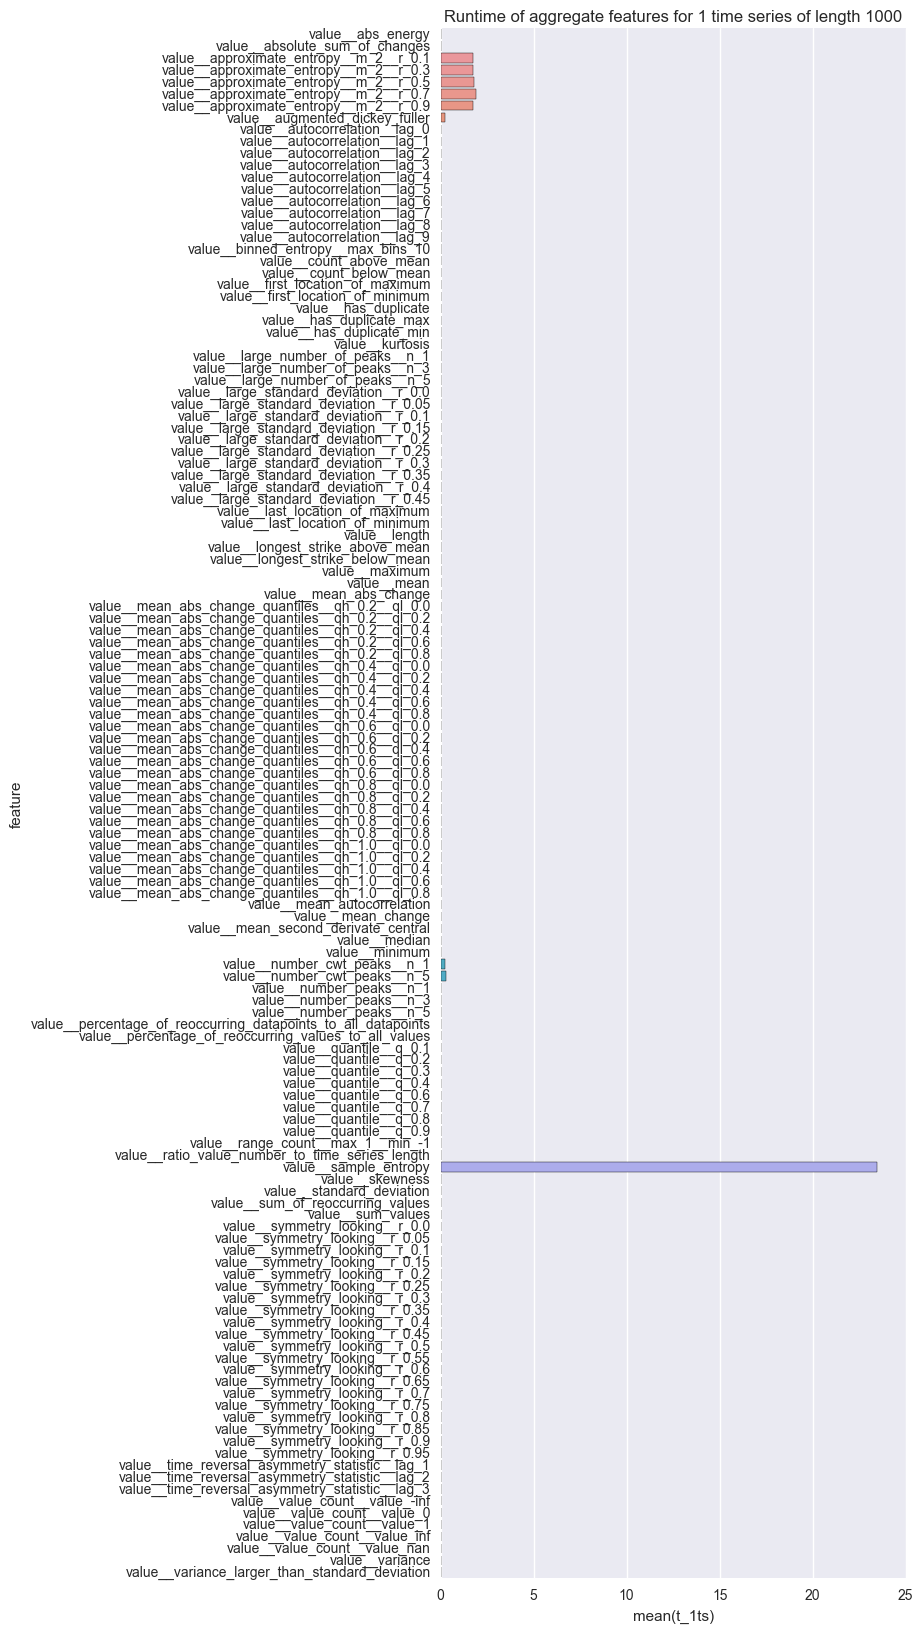

In [6]:
# compare performance of tsfresh for aggregate features that are calculated in groups
plt.figure(figsize=(6,20))
sns.barplot(y="feature", x="t_1ts", data=res)
plt.title("Runtime of aggregate features for 1 time series of length 1000")
plt.show()

In [7]:
# compare performance of tsfresh for apply features that are calculated in groups
res2  = pd.DataFrame()
n_ts = 20
l_ts = 1000
n_ti = 10

group = X.groupby("id")["value"]

for f, kwargs in tqdm(apply_functions):
    col = f.func_name
    res2.loc[col, "feature"] = col
    res2.loc[col, "n_samp"] = n_ts
    res2.loc[col, "length"] = l_ts
    t = timeit.timeit(lambda : group.apply(f, **kwargs).unstack(), number=n_ti)
    
    # apply features return more than one feature at a time, hence we have to devide by number of features
    n_fs = len(kwargs["param"])
    res2.loc[col, "n_fs"] = n_fs
    res2.loc[col, "t_abs"] = t * 1.0/ n_fs
    res2.loc[col, "t_1ts"] = t*1.0/(n_ts*n_fs)

100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


In [8]:
res2

,feature,n_samp,length,n_fs,t_abs,t_1ts
ar_coefficient,ar_coefficient,20.0,1000.0,5.0,0.131010,0.006550
index_mass_quantile,index_mass_quantile,20.0,1000.0,8.0,0.079257,0.003963
cwt_coefficients,cwt_coefficients,20.0,1000.0,60.0,0.014983,0.000749
fft_coefficient,fft_coefficient,20.0,1000.0,10.0,0.005248,0.000262
spkt_welch_density,spkt_welch_density,20.0,1000.0,3.0,0.023561,0.001178


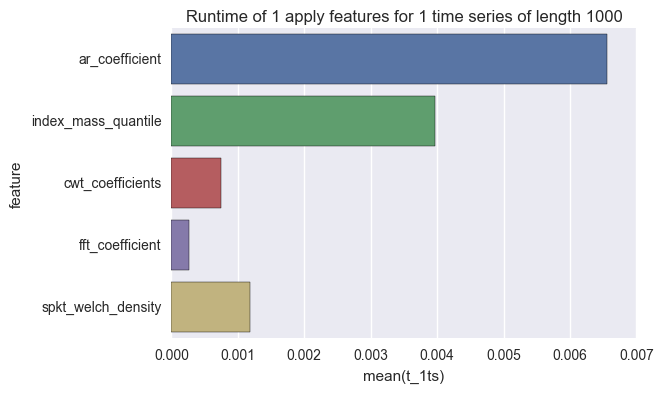

In [9]:
# compare performance of tsfresh for apply features that are calculated in groups
plt.figure(figsize=(6,4))
sns.barplot(y="feature", x="t_1ts", data=res2)
plt.title("Runtime of 1 apply features for 1 time series of length 1000")
plt.show()

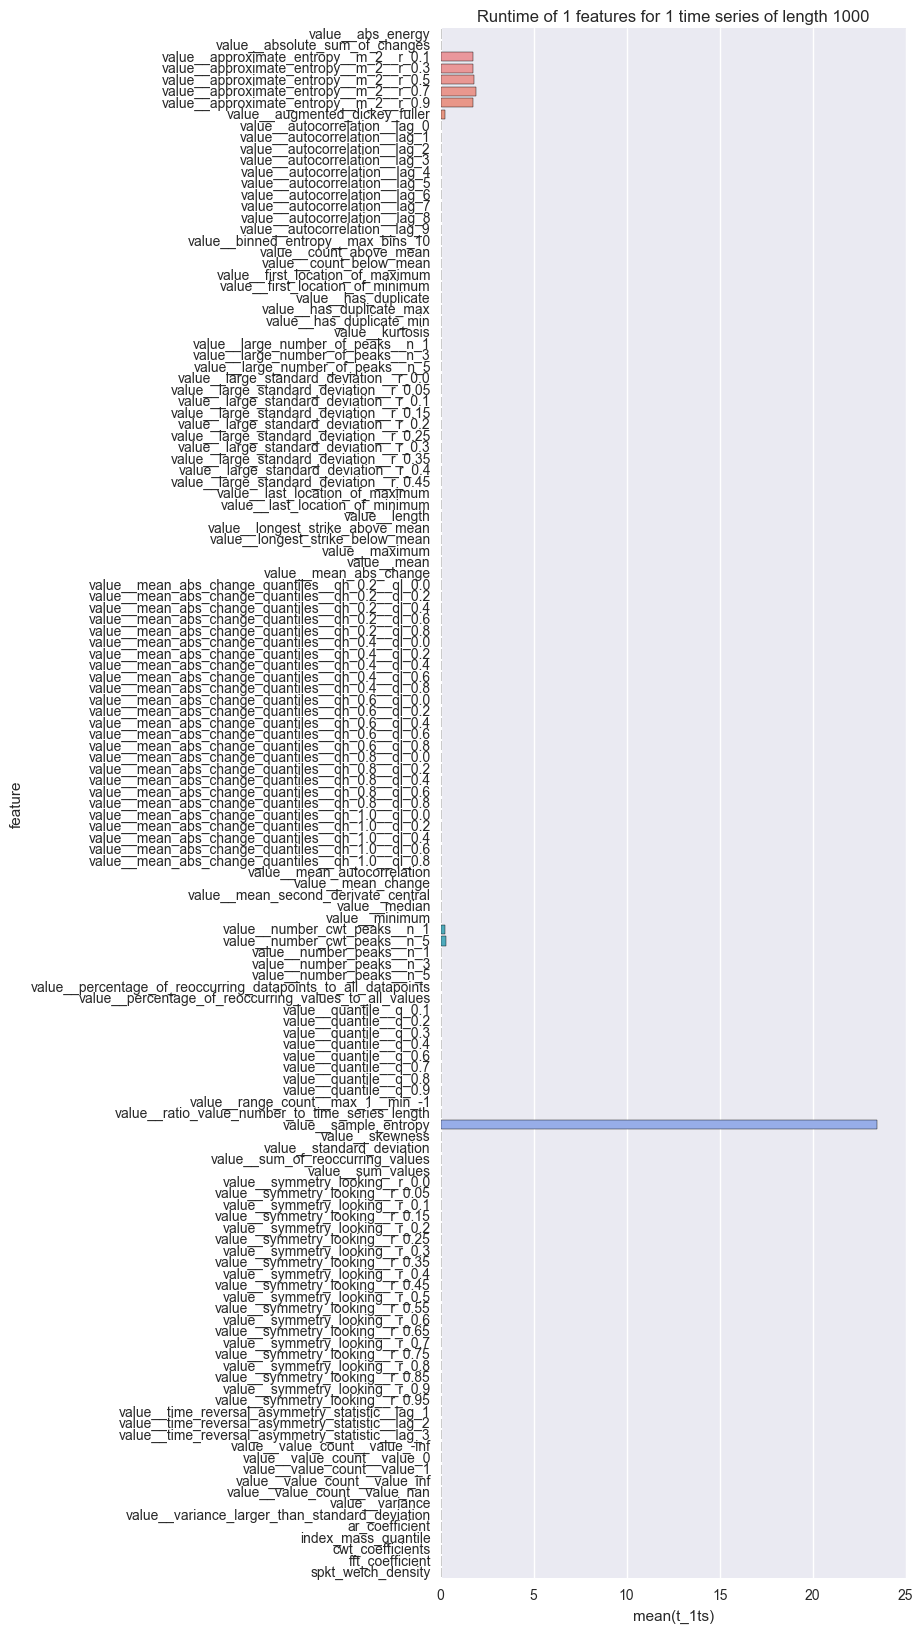

In [10]:
# Putting things into perspective
df = pd.concat([res, res2])

plt.figure(figsize=(6,20))
sns.barplot(y="feature", x="t_1ts", data=df)
plt.title("Runtime of 1 features for 1 time series of length 1000")
plt.show()

In [11]:
# we calculate how much many features cause 90% of the runtime 
r = df.t_1ts.copy()
r.sort(ascending=False)
r.cumsum() / r.sum()

/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


value__sample_entropy                               0.691060
value__approximate_entropy__m_2__r_0.7              0.746994
value__approximate_entropy__m_2__r_0.5              0.799234
value__approximate_entropy__m_2__r_0.1              0.851167
value__approximate_entropy__m_2__r_0.3              0.903092
value__approximate_entropy__m_2__r_0.9              0.954503
value__number_cwt_peaks__n_5                        0.962441
value__augmented_dickey_fuller                      0.970033
value__number_cwt_peaks__n_1                        0.976508
value__large_number_of_peaks__n_5                   0.977653
value__number_peaks__n_5                            0.978789
value__large_number_of_peaks__n_3                   0.979720
value__number_peaks__n_3                            0.980566
value__large_number_of_peaks__n_1                   0.981196
value__mean_abs_change_quantiles__qh_0.2__ql_0.6    0.981741
value__mean_abs_change_quantiles__qh_0.8__ql_0.0    0.982283
value__mean_abs_change_q

In [13]:
# we calculate how much many features cause 90% of the runtime 
r / r.sum()

value__sample_entropy                               0.691060
value__approximate_entropy__m_2__r_0.7              0.055935
value__approximate_entropy__m_2__r_0.5              0.052239
value__approximate_entropy__m_2__r_0.1              0.051933
value__approximate_entropy__m_2__r_0.3              0.051926
value__approximate_entropy__m_2__r_0.9              0.051411
value__number_cwt_peaks__n_5                        0.007938
value__augmented_dickey_fuller                      0.007592
value__number_cwt_peaks__n_1                        0.006474
value__large_number_of_peaks__n_5                   0.001145
value__number_peaks__n_5                            0.001136
value__large_number_of_peaks__n_3                   0.000931
value__number_peaks__n_3                            0.000847
value__large_number_of_peaks__n_1                   0.000630
value__mean_abs_change_quantiles__qh_0.2__ql_0.6    0.000544
value__mean_abs_change_quantiles__qh_0.8__ql_0.0    0.000542
value__mean_abs_change_q

In [12]:
# sample_entropy and approximate_entropy make up for most of the runtime